In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.ensemble import IsolationForest
from scipy.stats import shapiro
import ppscore as pps
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Step 1: Load the data and understand the data structure
   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  
0          2

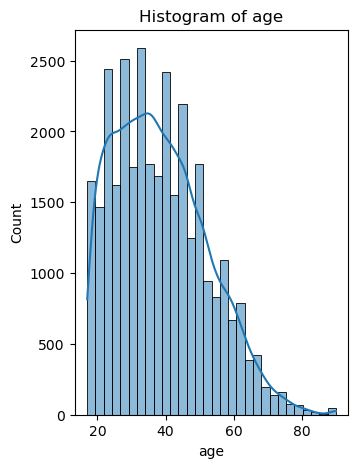

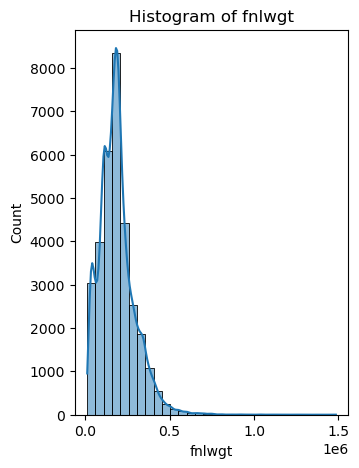

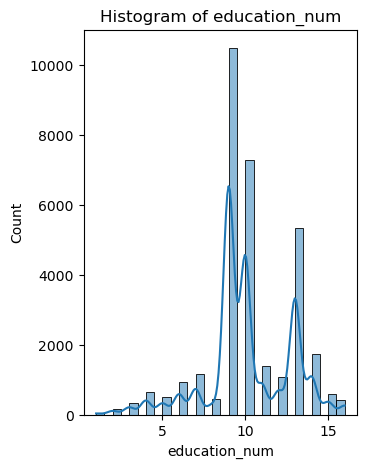

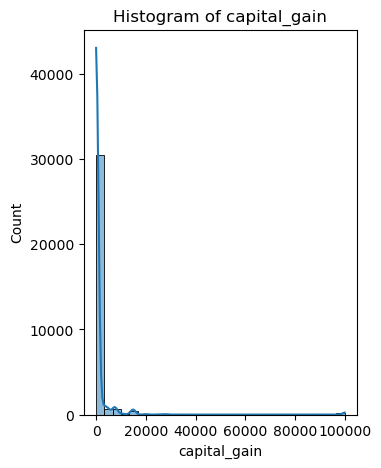

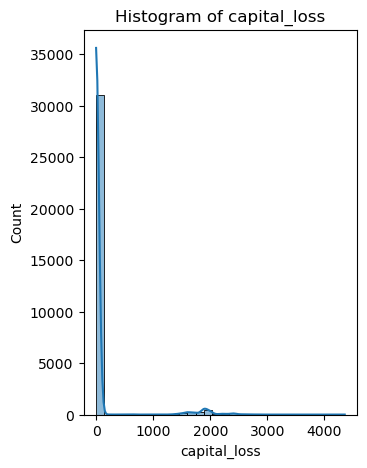

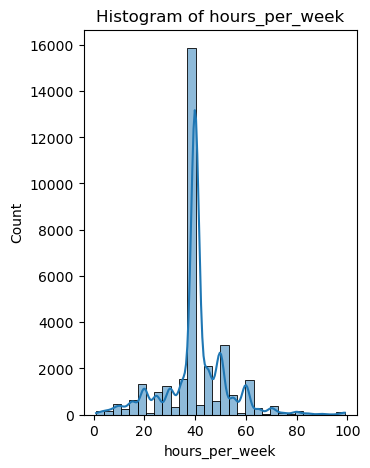


Shapiro-Wlk Test for age : Statistic=0.9668, p-value=0.0000

Shapiro-Wlk Test for fnlwgt : Statistic=0.9223, p-value=0.0000

Shapiro-Wlk Test for education_num : Statistic=0.9266, p-value=0.0000

Shapiro-Wlk Test for capital_gain : Statistic=0.1228, p-value=0.0000

Shapiro-Wlk Test for capital_loss : Statistic=0.2184, p-value=0.0000

Shapiro-Wlk Test for hours_per_week : Statistic=0.8851, p-value=0.0000

workclass: 9 unique categories

education: 16 unique categories

marital_status: 7 unique categories

occupation: 15 unique categories

relationship: 6 unique categories

race: 5 unique categories

sex: 2 unique categories

native_country: 42 unique categories

income: 2 unique categories

    age  workclass  fnlwgt  education  education_num  marital_status  \
0   39          7   77516          9             13               4   
1   50          6   83311          9             13               2   
2   38          4  215646         11              9               0   
3   53         

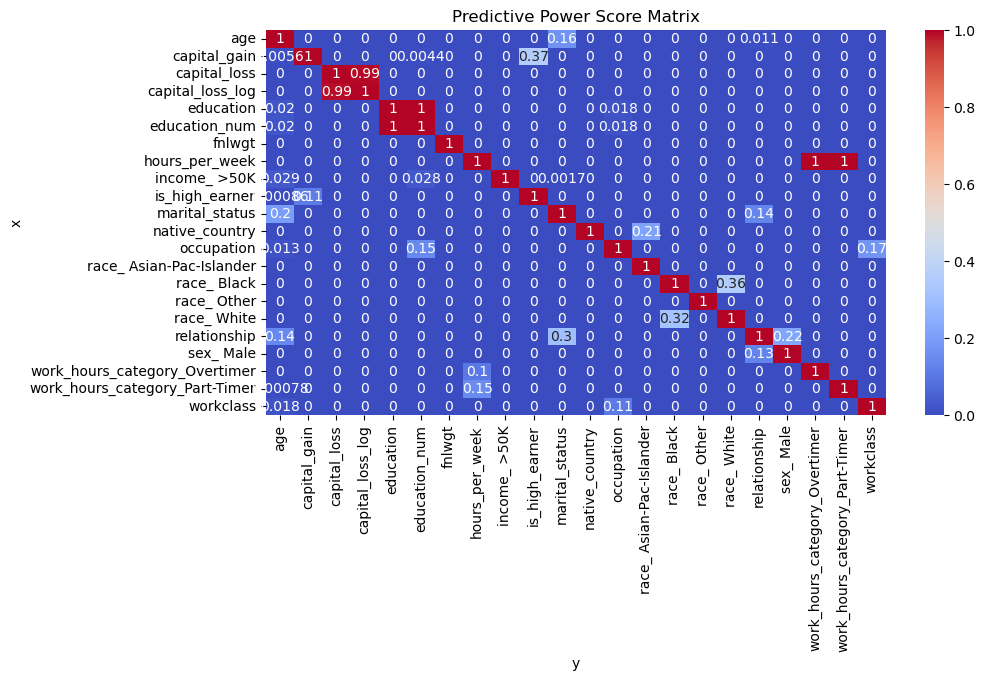

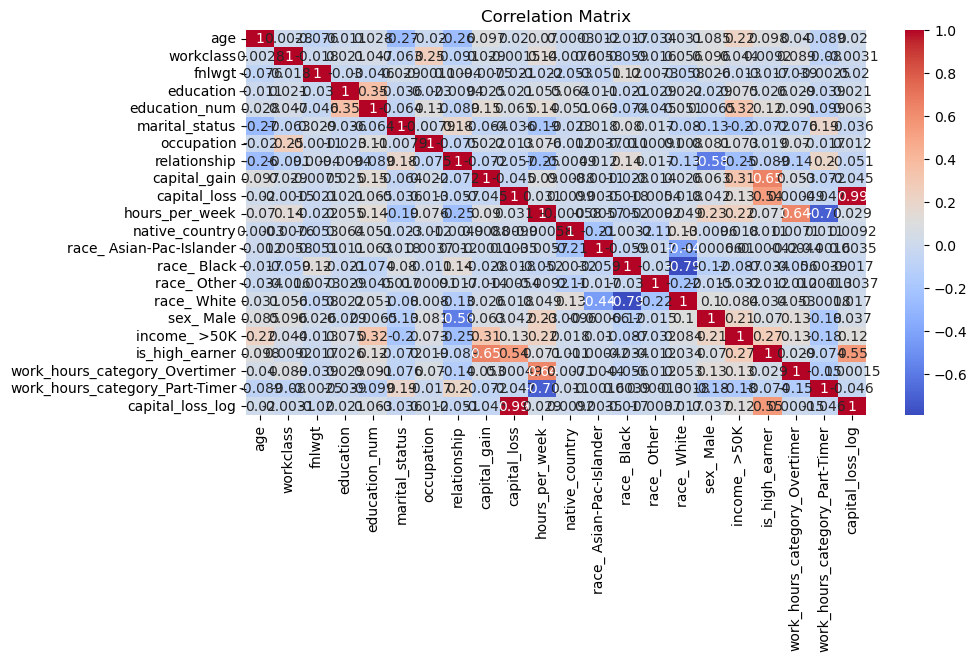

In [13]:
def EDA2():
    try:
        print("Step 1: Load the data and understand the data structure")
        df_adult = pd.read_csv("adult_with_headers.csv")

        print(df_adult.head())

        print("\nStep 2: Check the data types and column details\n")
        df_adult.info()

        print("\nOriginal Data")
        print("\n",df_adult.describe())
        print("\n",df_adult.dtypes)

        has_nan = df_adult.isna().any().any()
        print("\nDoes the Dataframe have any NaN values?", has_nan)

        count = df_adult.isnull().sum()
        print("\nFollowing is the count of missing values accordings to columns:\n",count)

        duplicates = df_adult.duplicated()
        print("\nCount of duplicate rows")
        print(duplicates.sum())

        df_adult_cleaned = df_adult.drop_duplicates()
        print(f"\nNumber of duplicates rows after removal: { df_adult_cleaned.duplicated().sum()}")

        print(df_adult_cleaned.head())

        #Scaling Numerical features
        numerical_col = df_adult_cleaned.select_dtypes(include=['int64','float64']).columns
        categorical_col = df_adult_cleaned.select_dtypes(include=['object']).columns
        print("\nNumerical column:\n",numerical_col)
        print("\nCategorical column:\n",categorical_col)

        for col in numerical_col:
            plt.figure(figsize=(12,5))

            #Histogram
            plt.subplot(1,3,1)
            sns.histplot(df_adult_cleaned[col], kde=True, bins=30)
            plt.title(f"Histogram of {col}")
            plt.show()

        for col in numerical_col:
            stat, p = shapiro(df_adult_cleaned[col])
            print(f"\nShapiro-Wlk Test for {col} : Statistic={stat:.4f}, p-value={p:.4f}")


        #Apply Min-Max Scaling
        scaler_minMax = MinMaxScaler()
        df_minMax_scaled = df_adult_cleaned.copy()
        df_minMax_scaled[numerical_col] = scaler_minMax.fit_transform(df_adult_cleaned[numerical_col])

        #Before applying encoding, we need to determine which categorical columns have less than 5 categories (one-hot encoding) and which have more than 5 categories(Label encoding)
        for col in categorical_col:
            print(f"\n{col}: {df_adult_cleaned[col].nunique()} unique categories")

        #Identify columns for One-hot Encoding and label encoding
        one_hot_col = [] #Store columns with <= 5 categories
        label_encode_col = [] #Store columnds with > 5 catrgories

        for col in categorical_col:
            if df_adult_cleaned[col].nunique() <=5:
                one_hot_col.append(col)
            else:
                label_encode_col.append(col)

        #Apply One-Hot encoding
        df_encoded = df_adult_cleaned.copy()
        df_encoded = pd.get_dummies(df_encoded, columns=one_hot_col, drop_first=True)

        #Apply label encoding
        label_encoder = LabelEncoder()
        for col in label_encode_col:
            df_encoded[col] = label_encoder.fit_transform(df_encoded[col])
        
        #Display transformed dataset
        print("\n",df_encoded.head())

        #Feature engineering
        df_encoded["is_high_earner"] = ((df_encoded["capital_gain"] > 0) | (df_encoded['capital_loss'] > 0)).astype(int)

        def categorical_hours(hours):
            if hours <= 30:
                return "Part-Timer"
            elif 31 <= hours <= 50:
                return "Full-Timer"
            else:
                return "Overtimer"
            
        df_encoded['work_hours_category'] = df_encoded["hours_per_week"].apply(categorical_hours)
        df_encoded = pd.get_dummies(df_encoded, columns=["work_hours_category"], drop_first=True)

        df_adult["captial_gain_log"] = np.log1p(df_encoded["capital_gain"]) #log1p to handle the missing values
        df_encoded['capital_loss_log'] = np.log1p(df_encoded["capital_loss"])

        #Apply isolation forest
        iso_forest = IsolationForest(contamination=0.02, random_state=42)
        outliers = iso_forest.fit_predict(df_encoded[numerical_col])

        #Mark outliers (-1) and remove them
        df_encoded['is_outlier']=outliers
        df_encoded = df_encoded[df_encoded["is_outlier"] != -1].drop(columns=["is_outlier"])

        #Compute PPS Matrix
        pps_matrix = pps.matrix(df_encoded)
        pps_matrix = pps_matrix.pivot(index="x", columns='y', values='ppscore')

        #Compute correlation matrix
        correlation_matrix = df_encoded.corr()

        #Plot PPS Matrix
        plt.figure(figsize=(10,5))
        sns.heatmap(pps_matrix, cmap='coolwarm', annot=True)
        plt.title("Predictive Power Score Matrix")
        plt.show()

        #Plot Corelation Matrix
        plt.figure(figsize=(10,5))
        sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
        plt.title("Correlation Matrix")
        plt.show()


    except FileNotFoundError:
        print("Error")



EDA2()